In [1]:
#@title Import required libraries
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.hub_utils import init_git_repo, push_to_hub
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4"

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

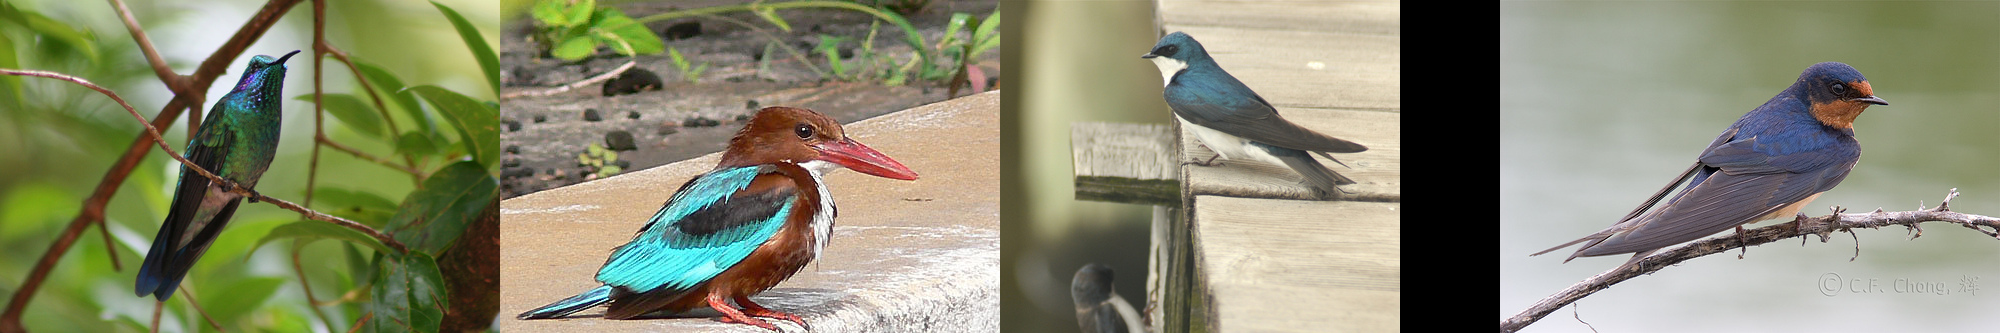

In [2]:
from torchvision.datasets.folder import default_loader


def convert_rgb(img):
  return default_loader(img)

images = []
for i in os.listdir('blue_wings_random_class'):
  images.append(convert_rgb('blue_wings_random_class/' + i))
image_grid(images, 1, len(images))


In [3]:
#@title Settings for your newly created concept
#@markdown `what_to_teach`: what is it that you are teaching? `object` enables you to teach the model a new object to be used, `style` allows you to teach the model a new style one can use.
what_to_teach = "object" #@param ["object", "style"]
#@markdown `placeholder_token` is the token you are going to use to represent your new concept (so when you prompt the model, you will say "A `<my-placeholder-token>` in an amusement park"). We use angle brackets to differentiate a token from other words/tokens, to avoid collision.
placeholder_token = "<bird-wing-color>" #@param {type:"string"}
#@markdown `initializer_token` is a word that can summarise what your new concept is, to be used as a starting point
initializer_token = "color" #@param {type:"string"}

#@title Setup the prompt templates for training 
imagenet_templates_small = [
    "a photo of a bird with {} wings",
    "a rendering of a bird with {} wings",
    "a cropped photo of bird with {} wings",
    "the photo of a bird with {} wings",
    "a photo of a clean bird with {} wings",
    "a photo of a dirty bird with {} wings",
    "a dark photo of bird with {} wings",
    "a photo of a bird with {} wings",
    "a close-up photo of a bird with {} wings",
    "a bright photo of a bird with {} wings",
    "a good photo of a bird with {} wings",
    "a photo of one bird with {} wings",
    "a close-up photo of a bird with {} wings",
    "a rendition of a bird with {} wings",
    "a photo of a nice bird with {} wings",
    "a good photo of a bird with {} wings",
    "a photo of the nice {}",
    "a photo of the small bird with {} wings",
    "a photo of the weird bird with {} wings",
    "a photo of the large bird with {} wings",
    "a photo of a cool bird with {} wings",
    "a photo of a small bird with {} wings",
]

'''imagenet_style_templates_small = [
    "a painting in the style of {}",
    "a rendering in the style of {}",
    "a cropped painting in the style of {}",
    "the painting in the style of {}",
    "a clean painting in the style of {}",
    "a dirty painting in the style of {}",
    "a dark painting in the style of {}",
    "a picture in the style of {}",
    "a cool painting in the style of {}",
    "a close-up painting in the style of {}",
    "a bright painting in the style of {}",
    "a cropped painting in the style of {}",
    "a good painting in the style of {}",
    "a close-up painting in the style of {}",
    "a rendition in the style of {}",
    "a nice painting in the style of {}",
    "a small painting in the style of {}",
    "a weird painting in the style of {}",
    "a large painting in the style of {}",
]'''

'imagenet_style_templates_small = [\n    "a painting in the style of {}",\n    "a rendering in the style of {}",\n    "a cropped painting in the style of {}",\n    "the painting in the style of {}",\n    "a clean painting in the style of {}",\n    "a dirty painting in the style of {}",\n    "a dark painting in the style of {}",\n    "a picture in the style of {}",\n    "a cool painting in the style of {}",\n    "a close-up painting in the style of {}",\n    "a bright painting in the style of {}",\n    "a cropped painting in the style of {}",\n    "a good painting in the style of {}",\n    "a close-up painting in the style of {}",\n    "a rendition in the style of {}",\n    "a nice painting in the style of {}",\n    "a small painting in the style of {}",\n    "a weird painting in the style of {}",\n    "a large painting in the style of {}",\n]'

In [4]:
#@title Setup the dataset
class TextualInversionDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        learnable_property="object",  # [object, style]
        size=512,
        repeats=100,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
        placeholder_token="*",
        center_crop=False,
    ):

        self.data_root = data_root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.size = size
        self.placeholder_token = placeholder_token
        self.center_crop = center_crop
        self.flip_p = flip_p

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)]

        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == "train":
            self._length = self.num_images * repeats

        self.interpolation = {
            "linear": PIL.Image.LINEAR,
            "bilinear": PIL.Image.BILINEAR,
            "bicubic": PIL.Image.BICUBIC,
            "lanczos": PIL.Image.LANCZOS,
        }[interpolation]

        self.templates = imagenet_style_templates_small if learnable_property == "style" else imagenet_templates_small
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        image = Image.open(self.image_paths[i % self.num_images])

        if not image.mode == "RGB":
            image = image.convert("RGB")

        placeholder_string = self.placeholder_token
        text = random.choice(self.templates).format(placeholder_string)

        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        # default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            h, w, = (
                img.shape[0],
                img.shape[1],
            )
            img = img[(h - crop) // 2 : (h + crop) // 2, (w - crop) // 2 : (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        return example

In [5]:
#@title Load the tokenizer and add the placeholder token as a additional special token.
#@markdown Please read and if you agree accept the LICENSE [here](https://huggingface.co/CompVis/stable-diffusion-v1-4) if you see an error
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)

# Add the placeholder token in tokenizer
num_added_tokens = tokenizer.add_tokens(placeholder_token)
if num_added_tokens == 0:
    raise ValueError(
        f"The tokenizer already contains the token {placeholder_token}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )
    
token_ids = tokenizer.encode(initializer_token, add_special_tokens=False)
# Check if initializer_token is a single token or a sequence of tokens
if len(token_ids) > 1:
    raise ValueError("The initializer token must be a single token.")

initializer_token_id = token_ids[0]
placeholder_token_id = tokenizer.convert_tokens_to_ids(placeholder_token)


#@title Load the Stable Diffusion model
# Load models and create wrapper for stable diffusion
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet"
)
text_encoder.resize_token_embeddings(len(tokenizer))
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id] = token_embeds[initializer_token_id]

In [6]:
def freeze_params(params):
    for param in params:
        param.requires_grad = False

# Freeze vae and unet
freeze_params(vae.parameters())
freeze_params(unet.parameters())
# Freeze all parameters except for the token embeddings in text encoder
params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
freeze_params(params_to_freeze)

In [7]:
train_dataset = TextualInversionDataset(
      data_root='blue_wings_random_class',
      tokenizer=tokenizer,
      size=512,
      placeholder_token=placeholder_token,
      repeats=100,
      learnable_property=what_to_teach, #Option selected above between object and style
      center_crop=False,
      set="train",
)
def create_dataloader(train_batch_size=1):
    return torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

noise_scheduler = DDPMScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000, tensor_format="pt"
)

hyperparameters = {
    "learning_rate": 5e-04,
    "scale_lr": True,
    "max_train_steps": 3000,
    "train_batch_size": 1,
    "gradient_accumulation_steps": 4,
    "seed": 42,
    "output_dir": "blue-wings-random-class-concept"
}

In [8]:
def training_function(text_encoder, vae, unet):
    logger = get_logger(__name__)

    train_batch_size = hyperparameters["train_batch_size"]
    gradient_accumulation_steps = hyperparameters["gradient_accumulation_steps"]
    learning_rate = hyperparameters["learning_rate"]
    max_train_steps = hyperparameters["max_train_steps"]
    output_dir = hyperparameters["output_dir"]

    accelerator = Accelerator(
        gradient_accumulation_steps=gradient_accumulation_steps,
    )

    train_dataloader = create_dataloader(train_batch_size)

    if hyperparameters["scale_lr"]:
        learning_rate = (
            learning_rate * gradient_accumulation_steps * train_batch_size * accelerator.num_processes
        )

    # Initialize the optimizer
    optimizer = torch.optim.AdamW(
        text_encoder.get_input_embeddings().parameters(),  # only optimize the embeddings
        lr=learning_rate,
    )


    text_encoder, optimizer, train_dataloader = accelerator.prepare(
        text_encoder, optimizer, train_dataloader
    )

    # Move vae and unet to device
    vae.to(accelerator.device)
    unet.to(accelerator.device)

    # Keep vae and unet in eval model as we don't train these
    vae.eval()
    unet.eval()

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        text_encoder.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(text_encoder):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"]).latent_dist.sample().detach()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn(latents.shape).to(latents.device)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                loss = F.mse_loss(noise_pred, noise, reduction="none").mean([1, 2, 3]).mean()
                accelerator.backward(loss)

                # Zero out the gradients for all token embeddings except the newly added
                # embeddings for the concept, as we only want to optimize the concept embeddings
                if accelerator.num_processes > 1:
                    grads = text_encoder.module.get_input_embeddings().weight.grad
                else:
                    grads = text_encoder.get_input_embeddings().weight.grad
                # Get the index for tokens that we want to zero the grads for
                index_grads_to_zero = torch.arange(len(tokenizer)) != placeholder_token_id
                grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)

                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= max_train_steps:
                break

        accelerator.wait_for_everyone()


    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline(
            text_encoder=accelerator.unwrap_model(text_encoder),
            vae=vae,
            unet=unet,
            tokenizer=tokenizer,
            scheduler=PNDMScheduler(
                beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", skip_prk_steps=True
            ),
            safety_checker=StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker"),
            feature_extractor=CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32"),
        )
        pipeline.save_pretrained(output_dir)
        # Also save the newly trained embeddings
        learned_embeds = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id]
        learned_embeds_dict = {placeholder_token: learned_embeds.detach().cpu()}
        torch.save(learned_embeds_dict, os.path.join(output_dir, "learned_embeds.bin"))

In [9]:
'''import accelerate
accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet), num_processes = 1)'''

'import accelerate\naccelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet), num_processes = 1)'

In [10]:
#@title Set up the pipeline 
pipe = StableDiffusionPipeline.from_pretrained(
    hyperparameters["output_dir"],
    torch_dtype=torch.float16,
).to("cuda")

prompt = "a photo of a bird with <bird-wing-color> wings" #@param {type:"string"}

num_samples = 4 #@param {type:"number"}
num_rows = 2 #@param {type:"number"}

all_images = [] 
for _ in range(num_rows):
    images = pipe([prompt] * num_samples, num_inference_steps=50, guidance_scale=7.5).images
    all_images.extend(images)

grid = image_grid(all_images, num_samples, num_rows)
grid

  0%|          | 0/51 [00:00<?, ?it/s]

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /tmp/ipykernel_12008/2774860306.py:14 in <cell line: 13>                                  │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_12008/2774860306.py'                 │
│ /opt/conda/envs/pytorch/lib/python3.9/site-packages/torch/autograd/grad_mode.py:27 in     │
│ decorate_context                                                                          │
│                                                                                           │
│    24 │   │   @functools.wraps(func)                                                      │
│    25 │   │   def decorate_context(*args, **kwargs):                                      │
│    26 │   │   │   with self.clone():                                                      │
│ ❱  27 │   │   │   │   return func(*args, **kwargs)                                        │
│    28 │   │   return cast(F, decorate_context)                                            │
│    29 │                                                                                   │
│    30 │   def _wrap_generator(self, func):                                                │
│                                                                                           │
│ /home/ec2-user/.local/lib/python3.9/site-packages/diffusers/pipelines/stable_diffusion/pi │
│ peline_stable_diffusion.py:312 in __call__                                                │
│                                                                                           │
│   309 │   │   │   latent_model_input = self.scheduler.scale_model_input(latent_model_inpu │
│   310 │   │   │                                                                           │
│   311 │   │   │   # predict the noise residual                                            │
│ ❱ 312 │   │   │   noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=tex │
│   313 │   │   │                                                                           │
│   314 │   │   │   # perform guidance                                                      │
│   315 │   │   │   if do_classifier_free_guidance:                                         │
│                                                                                           │
│ /opt/conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/modules/module.py:1130 in    │
│ _call_impl                                                                                │
│                                                                                           │
│   1127 │   │   # this function, and just call forward.                                    │
│   1128 │   │   if not (self._backward_hooks or self._forward_hooks or self._forward_pre_h │
│   1129 │   │   │   │   or _global_forward_hooks or _global_forward_pre_hooks):            │
│ ❱ 1130 │   │   │   return forward_call(*input, **kwargs)                                  │
│   1131 │   │   # Do not call functions when jit is used                                   │
│   1132 │   │   full_backward_hooks, non_full_backward_hooks = [], []                      │
│   1133 │   │   if self._backward_hooks or _global_backward_hooks:                         │
│                                                                                           │
│ /home/ec2-user/.local/lib/python3.9/site-packages/diffusers/models/unet_2d_condition.py:2 │
│ 83 in forward                                                                             │
│                                                                                           │
│   280 │   │   down_block_res_samples = (sample,)                                          │
│   281 │   │   for downsample_block in self.down_bl

In [21]:
from scipy import spatial
token_id = pipe.tokenizer.convert_tokens_to_ids(placeholder_token)
token_embeds = text_encoder.get_input_embeddings().weight.data.cpu()
color_to_attribute_idx = {'blue': 0,'brown': 1,'iridescent': 2,
                                'purple': 3,'rufous': 4,'grey': 5,
                                'yellow': 6,'olive': 7,'green': 8,
                                'pink': 9,'orange': 10,'black': 11,
                                'white':12 ,'red': 13,'buff': 14}
cosine_sims = []
for i in color_to_attribute_idx:
    new_idx = pipe.tokenizer.convert_tokens_to_ids(i)
    cosine_sim = 1 - spatial.distance.cosine(token_embeds[token_id], token_embeds[new_idx])
    cosine_sims.append([i, cosine_sim])
cosine_sims

[['blue', 0.05273596942424774],
 ['brown', -0.008481266908347607],
 ['iridescent', -0.02947661280632019],
 ['purple', 0.002499062567949295],
 ['rufous', -0.02947661280632019],
 ['grey', -0.09194879978895187],
 ['yellow', 0.012271669693291187],
 ['olive', -0.038117434829473495],
 ['green', -0.018077529966831207],
 ['pink', -0.09296594560146332],
 ['orange', 0.007666889112442732],
 ['black', 0.02279391512274742],
 ['white', 0.03565777838230133],
 ['red', -0.0054758512414991856],
 ['buff', -0.019948821514844894]]

In [24]:
from scipy import spatial
token_id = pipe.tokenizer.convert_tokens_to_ids(placeholder_token)
token_embeds = text_encoder.get_input_embeddings().weight.data.cpu()
color_to_attribute_idx = {'blue': 0,'brown': 1,'iridescent': 2,
                                'purple': 3,'rufous': 4,'grey': 5,
                                'yellow': 6,'olive': 7,'green': 8,
                                'pink': 9,'orange': 10,'black': 11,
                                'white':12 ,'red': 13,'buff': 14}
euclidean_distances = []
for i in color_to_attribute_idx:
    new_idx = pipe.tokenizer.convert_tokens_to_ids(i)
    euclidean_distance = spatial.distance.euclidean(token_embeds[token_id], token_embeds[new_idx])
    euclidean_distances.append([i, euclidean_distance])
euclidean_distances

[['blue', 3.009930372238159],
 ['brown', 3.0330116748809814],
 ['iridescent', 3.2076077461242676],
 ['purple', 3.02864146232605],
 ['rufous', 3.2076077461242676],
 ['grey', 3.06432843208313],
 ['yellow', 3.0264546871185303],
 ['olive', 3.040278196334839],
 ['green', 3.034818410873413],
 ['pink', 3.0614635944366455],
 ['orange', 3.025838613510132],
 ['black', 3.020275115966797],
 ['white', 3.0165414810180664],
 ['red', 3.029366970062256],
 ['buff', 3.0388197898864746]]